Epoch 1: Loss = 1.0743
Epoch 2: Loss = 0.8705
Epoch 3: Loss = 0.7288
Epoch 4: Loss = 0.6426
Epoch 5: Loss = 0.5850
Epoch 6: Loss = 0.5342
Epoch 7: Loss = 0.4912
Epoch 8: Loss = 0.4574
Epoch 9: Loss = 0.4245
Epoch 10: Loss = 0.4038
Epoch 11: Loss = 0.3761
Epoch 12: Loss = 0.3638
Epoch 13: Loss = 0.3306
Epoch 14: Loss = 0.3188
Epoch 15: Loss = 0.2956
Epoch 16: Loss = 0.2792
Epoch 17: Loss = 0.2673
Epoch 18: Loss = 0.2580
Epoch 19: Loss = 0.2436
Epoch 20: Loss = 0.2324
Epoch 21: Loss = 0.2256
Epoch 22: Loss = 0.2120
Epoch 23: Loss = 0.2027
Epoch 24: Loss = 0.1978
Epoch 25: Loss = 0.1883
✅ 模型已保存：hair_seg_u2net.pth
✅ 已保存：./inpainted_results/inpainted_ISIC2019_0000461.jpg


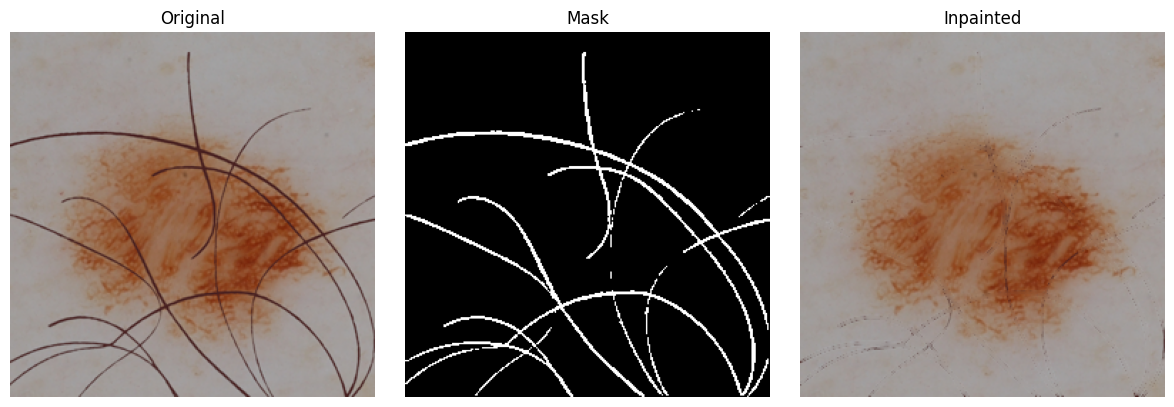

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


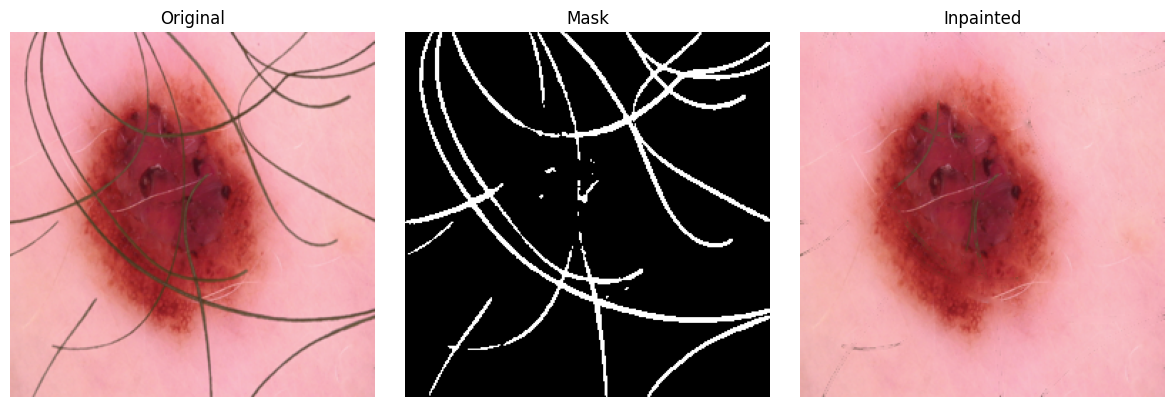

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


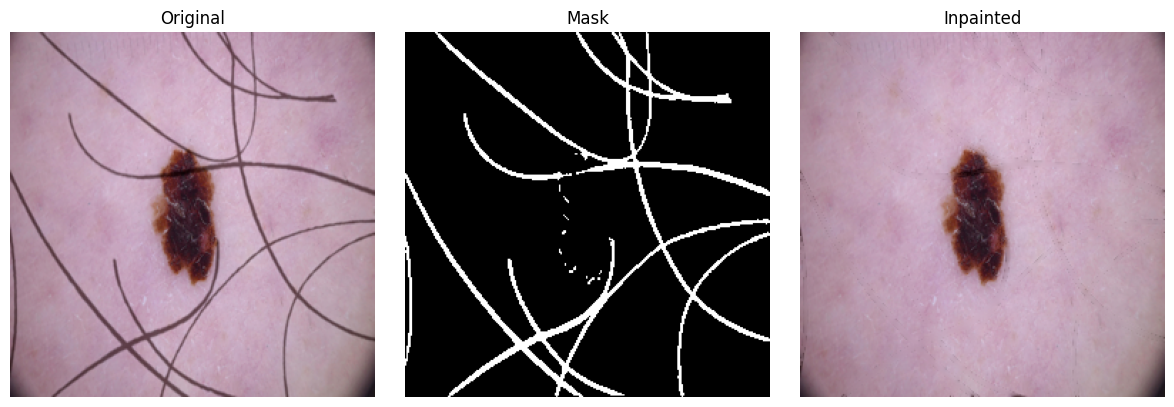

In [1]:
#U2net

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---------- 1. 数据集 ----------
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return img, mask

# ---------- 2. 模型结构（U²-Net 简化版） ----------
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class RSU7(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.stage1 = REBNCONV(out_ch, mid_ch)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage2 = REBNCONV(mid_ch, mid_ch)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage3 = REBNCONV(mid_ch, mid_ch)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage4 = REBNCONV(mid_ch, mid_ch)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage5 = REBNCONV(mid_ch, mid_ch)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage6 = REBNCONV(mid_ch, mid_ch)
        self.pool6 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage7 = REBNCONV(mid_ch, mid_ch)

        self.stage6d = REBNCONV(mid_ch*2, mid_ch)
        self.stage5d = REBNCONV(mid_ch*2, mid_ch)
        self.stage4d = REBNCONV(mid_ch*2, mid_ch)
        self.stage3d = REBNCONV(mid_ch*2, mid_ch)
        self.stage2d = REBNCONV(mid_ch*2, mid_ch)
        self.stage1d = REBNCONV(mid_ch*2, out_ch)

    def forward(self, x):
        hx = x
        hxin = self.rebnconvin(hx)
    
        hx1 = self.stage1(hxin)
        hx2 = self.stage2(self.pool1(hx1))
        hx3 = self.stage3(self.pool2(hx2))
        hx4 = self.stage4(self.pool3(hx3))
        hx5 = self.stage5(self.pool4(hx4))
        hx6 = self.stage6(self.pool5(hx5))
        hx7 = self.stage7(self.pool6(hx6))
    
        # ✨ 加上这一句：将 hx7 上采样到 hx6 尺寸
        hx7_up = nn.functional.interpolate(hx7, size=hx6.size()[2:], mode='bilinear', align_corners=False)
        hx6d = self.stage6d(torch.cat((hx7_up, hx6), dim=1))
    
        hx5_up = nn.functional.interpolate(hx6d, size=hx5.size()[2:], mode='bilinear', align_corners=False)
        hx5d = self.stage5d(torch.cat((hx5_up, hx5), dim=1))
    
        hx4_up = nn.functional.interpolate(hx5d, size=hx4.size()[2:], mode='bilinear', align_corners=False)
        hx4d = self.stage4d(torch.cat((hx4_up, hx4), dim=1))
    
        hx3_up = nn.functional.interpolate(hx4d, size=hx3.size()[2:], mode='bilinear', align_corners=False)
        hx3d = self.stage3d(torch.cat((hx3_up, hx3), dim=1))
    
        hx2_up = nn.functional.interpolate(hx3d, size=hx2.size()[2:], mode='bilinear', align_corners=False)
        hx2d = self.stage2d(torch.cat((hx2_up, hx2), dim=1))
    
        hx1_up = nn.functional.interpolate(hx2d, size=hx1.size()[2:], mode='bilinear', align_corners=False)
        hx1d = self.stage1d(torch.cat((hx1_up, hx1), dim=1))
    
        return hx1d + hxin


class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.stage1 = RSU7(in_ch, 32, 64)
        self.outconv = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x = self.stage1(x)
        x = self.outconv(x)
        return torch.sigmoid(x)

# ---------- 3. 数据准备 ----------
transform_img = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = HairMaskDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    mask_dir="/root/autodl-fs/skin_hair_dataset/alignment/mask",
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ---------- 4. 模型训练 ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = U2NET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

for epoch in range(25):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "hair_seg_u2net.pth")
print("✅ 模型已保存：hair_seg_u2net.pth")

# ---------- 5. 毛发去除函数 ----------
def inpaint_image(image_path, save_path=None):
    model.eval()
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return image_cv, binary_mask, inpainted

# ---------- 6. 测试、可视化与保存 Inpainted 图像 ----------
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()


✅ 已保存：./inpainted_results/inpainted_ISIC2019_0000461.jpg


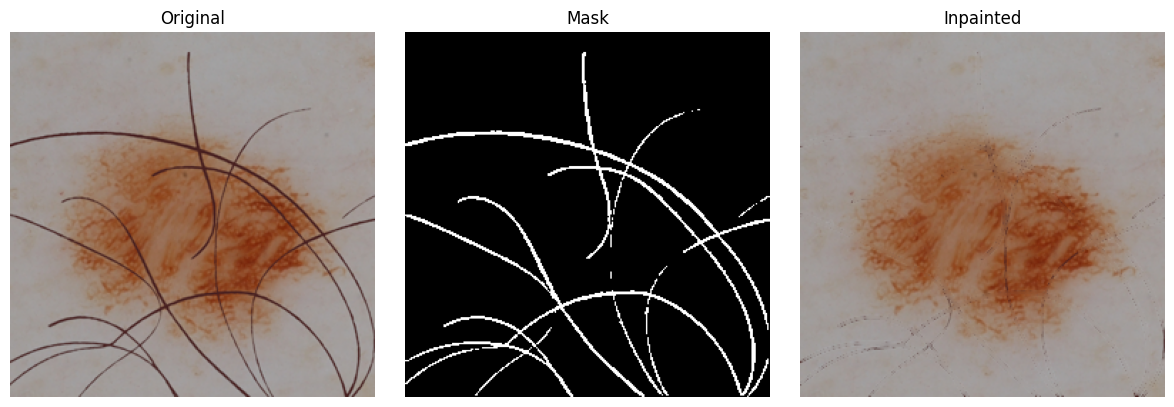

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


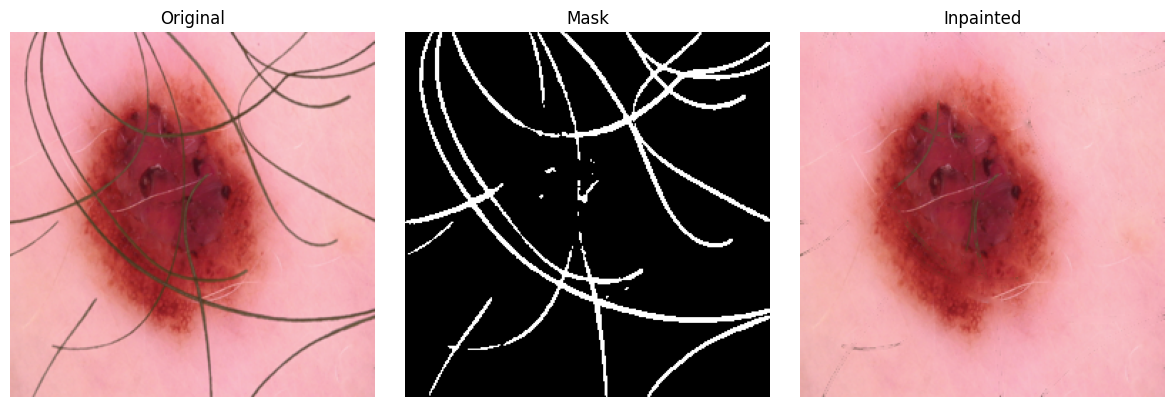

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


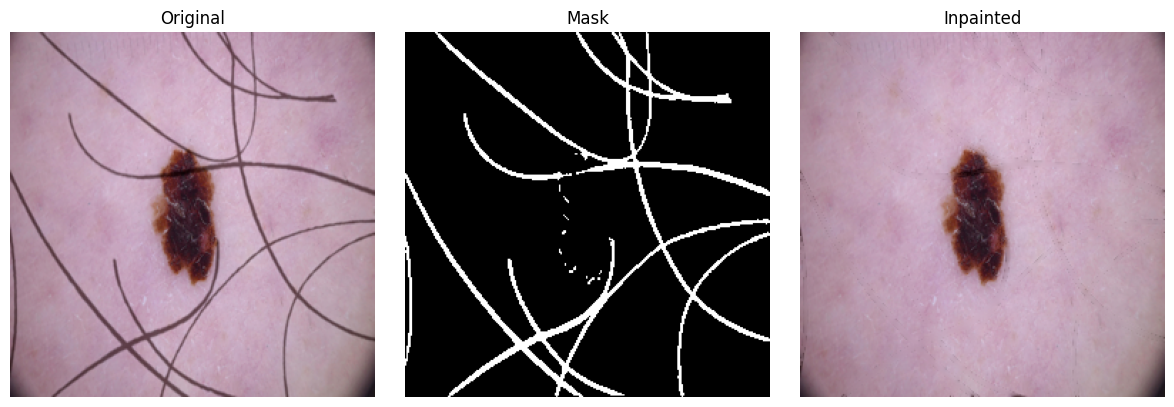

In [2]:
# ---------- 6. 测试、可视化与保存 Inpainted 图像 ----------
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [5]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ---------- 7. 图像质量指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val

image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
original_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 没有毛发的 ground-truth 原图
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 累加指标
total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理修复图像
        img_path = os.path.join(image_dir, img_name)
        original, _, inpainted = inpaint_image(img_path)

        # 加载 ground-truth（无毛发）图像
        gt_path = os.path.join(original_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1
        print(f"✅ {img_name}  |  MSE: {mse:.4f}  PSNR: {psnr:.2f}  SSIM: {ssim:.4f}  UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败 {img_name}：{str(e)}")

# 平均指标打印
if valid_count > 0:
    print("\n📊 平均指标：")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")


✅ ISIC2017_0000026.jpg  |  MSE: 0.0015  PSNR: 28.26  SSIM: 0.9801  UQI: 0.9998
✅ ISIC2017_0000081.jpg  |  MSE: 0.0004  PSNR: 33.93  SSIM: 0.8851  UQI: 0.9994
✅ ISIC2017_0000082.jpg  |  MSE: 0.0001  PSNR: 40.15  SSIM: 0.9476  UQI: 0.9989
✅ ISIC2017_0000147.jpg  |  MSE: 0.0005  PSNR: 32.98  SSIM: 0.9186  UQI: 0.9982
✅ ISIC2017_0000150.jpg  |  MSE: 0.0002  PSNR: 37.10  SSIM: 0.9212  UQI: 0.9987
✅ ISIC2017_0000151.jpg  |  MSE: 0.0001  PSNR: 38.63  SSIM: 0.9366  UQI: 0.9986
✅ ISIC2017_0000152.jpg  |  MSE: 0.0003  PSNR: 34.65  SSIM: 0.9119  UQI: 0.9968
✅ ISIC2017_0000153.jpg  |  MSE: 0.0002  PSNR: 38.00  SSIM: 0.9274  UQI: 0.9997
✅ ISIC2017_0000154.jpg  |  MSE: 0.0002  PSNR: 37.91  SSIM: 0.9363  UQI: 0.9995
✅ ISIC2017_0001148.jpg  |  MSE: 0.0001  PSNR: 40.51  SSIM: 0.9580  UQI: 0.9998
✅ ISIC2017_0012137.jpg  |  MSE: 0.0004  PSNR: 34.46  SSIM: 0.9004  UQI: 0.9992
✅ ISIC2017_0015079.jpg  |  MSE: 0.0005  PSNR: 33.18  SSIM: 0.8626  UQI: 0.9963
✅ ISIC2019_0000171.jpg  |  MSE: 0.0015  PSNR: 28.16 